# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 17th of february at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [ ]:
%matplotlib inline

In [ ]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit
import math

In [ ]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [ ]:
print(numba.__version__) # Your version of Numba

0.56.4


In [ ]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [ ]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [ ]:
%timeit go_fast(x)

1.31 µs ± 27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [ ]:
%timeit go_fast.py_func(x)

18.5 µs ± 228 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [ ]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [ ]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [ ]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [ ]:
toeplitz(0.5 ** np.arange(0, 10))

array([[1.        , 0.5       , 0.25      , 0.125     , 0.0625    ,
        0.03125   , 0.015625  , 0.0078125 , 0.00390625, 0.00195312],
       [0.5       , 1.        , 0.5       , 0.25      , 0.125     ,
        0.0625    , 0.03125   , 0.015625  , 0.0078125 , 0.00390625],
       [0.25      , 0.5       , 1.        , 0.5       , 0.25      ,
        0.125     , 0.0625    , 0.03125   , 0.015625  , 0.0078125 ],
       [0.125     , 0.25      , 0.5       , 1.        , 0.5       ,
        0.25      , 0.125     , 0.0625    , 0.03125   , 0.015625  ],
       [0.0625    , 0.125     , 0.25      , 0.5       , 1.        ,
        0.5       , 0.25      , 0.125     , 0.0625    , 0.03125   ],
       [0.03125   , 0.0625    , 0.125     , 0.25      , 0.5       ,
        1.        , 0.5       , 0.25      , 0.125     , 0.0625    ],
       [0.015625  , 0.03125   , 0.0625    , 0.125     , 0.25      ,
        0.5       , 1.        , 0.5       , 0.25      , 0.125     ],
       [0.0078125 , 0.015625  , 0.03125  

In [ ]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [ ]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

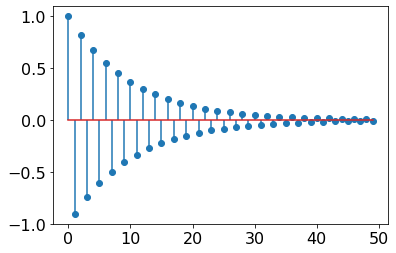

In [ ]:
plt.stem(x_model_truth,use_line_collection=True);

### Numerically check loss and gradient

In [ ]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.5024822209215588e-06

In [ ]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.8962211141270305e-07

### Choice of the model

In [ ]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [ ]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06143178848280652


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5248195293966591
9.947557593206904e-09


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD)

### Define a class to monitor iterations

In [ ]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [ ]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [ ]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        xt = x
        x = xt- step*grad(xt, *args)

        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [ ]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
      yt = y
      xt = x
      x = yt - step *grad(yt, *args)
      tk = t
      t= (1 + math.sqrt(1+4*tk **2))/2
      y= x +(tk/t) *(x -xt)
      if i % store_every == 0:
          x_list.append(x.copy())
      ### TODO
    return x, x_list

In [ ]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [ ]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)

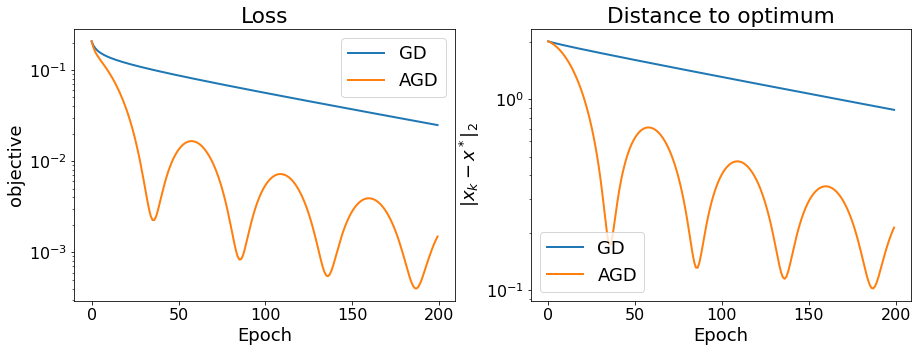

In [ ]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

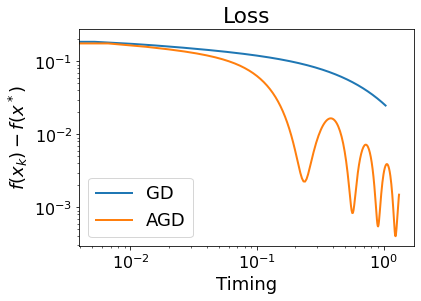

In [ ]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

* We observe three different plots: **The loss and the distance to minimum as function of epochs, and the loss as function of time**
* The two first plots show that the Gradient Descent (GD) is more stable than Accelerated Gradient Descent (AGD) with less oscillations. However, the common point is that both curves are descreasing which shows that two methods help approaching to the min.
* The convergence shown with GD is linear, with no oscillations (GD relys on the 'relaxation sequence property'.
* The APGD, however, approaches to the min faster than GD, and when it comes closer, it starts oscillating around it: It is taking U-turns when approaching the minima valleys.
* The third curve prooves that in the first place, both the algorithms perform similarly, than the AGD reaches faster the objective function. (it still shows the oscillations)
* The results about AGD are not surprising, since the AGD do not rely on the relaxation proprety like GD, and thus, the objective function is not supposed to decrease after each operation. 

<a id='stoc'></a> 
## 4. Stochastic methods

In [ ]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [ ]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
      
        x -=  (step /math.sqrt(idx+1)) *grad_i(i,x, *args)
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [ ]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        ### TODO
        averaged_gradient += (grad_i(i,x,*args) - gradient_memory[i][:]) / n 
        gradient_memory[i][:] = grad_i(i,x,*args)
        x -= step*averaged_gradient
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [ ]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        ### TODO     
        
        if idx % n == 0:
          x_old = x.copy()
          grad_old = grad(x_old,*args).copy()
        i = random_indices[idx]
        grad_x = grad_i(i, x, *args) - grad_i(i, x_old, *args) + grad_old
        x -= step*grad_x

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter*n , step, args=(A, b, lbda))

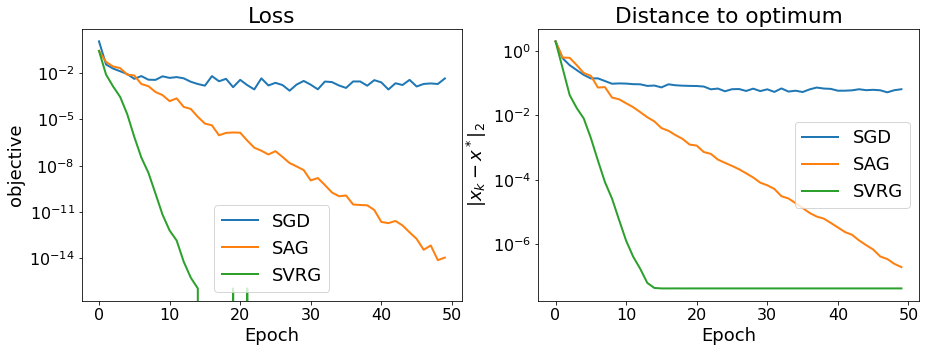

In [ ]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

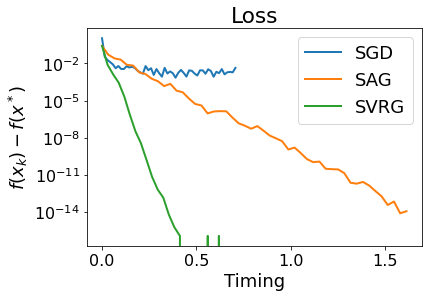

In [ ]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

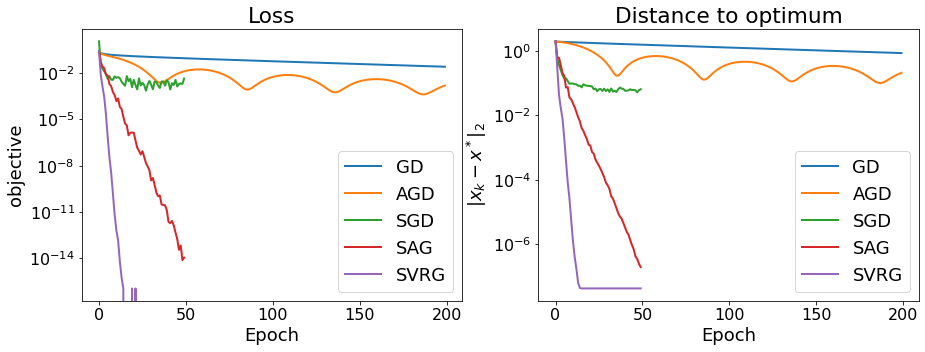

In [ ]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

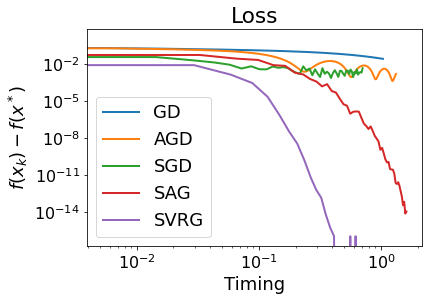

In [ ]:
plot_time(monitors, solvers, xscale='log')

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

**1. Comparing the results of the 5 algorithms we can tell that:**
* The fastest algorithm of all is the SVRG: It converges after only 10 epochs. It also doesn't contain any oscillations like the AGD, SGD and SAG(less obviously).
* Also, we noticed that overall, the stochastic methods converge faster than the batch gradient methods. This is mainly explicable with the fact that it updates the weights more frequently. 
* If we rate performances from best to worst here is the rating according to the figures above:  **SVRG => SAG => SGD => AGD => GD** 

**2 and 3-**The function bellow plot the results of the optimization algorithms for values of the regularization parameter and the correlation that are given as parameters:

In [ ]:
def parameters_change(lamb = 1/(n**0.5) , corr=0.9):
  A, b = simu_linreg(x_model_truth, n, std=1.,corr=corr)
  loss = loss_linreg
  grad = grad_linreg
  grad_i = grad_i_linreg
  lipschitz_constant = lipschitz_linreg
  step = 1. / lipschitz_constant(A, b, lamb)
  print("step = %s" % step)
  x_init = np.zeros(d)
  x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,args=(A, b, lamb), pgtol=1e-30, factr=1e-30)
  print(f_min)
  print(norm(grad_linreg(x_min, A, b, lamb)))
  # GD
  n_iter = 200
  monitor_gd = monitor(gd, loss, x_min, (A, b ,lamb))
  monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lamb))
  # AGD
  monitor_agd = monitor(agd, loss, x_min, (A, b ,lamb))
  monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lamb))
  # stochastic methods
  n_iter = 50
  random_indices = np.random.randint(0, n, n * n_iter)
  #sgd:
  step2 = 1e-1
  monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lamb))
  monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step2, args=(A, b, lamb))
  #sag:
  max_squared_sum = np.max(np.sum(A ** 2, axis=1))
  step3 = 1.0 / (max_squared_sum + lamb)
  monitor_sag = monitor(sag, loss, x_min, (A, b ,lamb))
  monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step3, args=(A, b, lamb))
  #svrg:
  monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lamb))
  monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter *n , step3, args=(A, b, lamb))
  monitors = [monitor_gd, monitor_agd, monitor_sgd, monitor_sag, monitor_svrg]
  solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]
  plot_epochs(monitors, solvers)
  plt.show()
  plot_time(monitors, solvers, xscale='log') 

step = 0.06224600108599382
0.5042052433661655
1.4881531673590237e-08


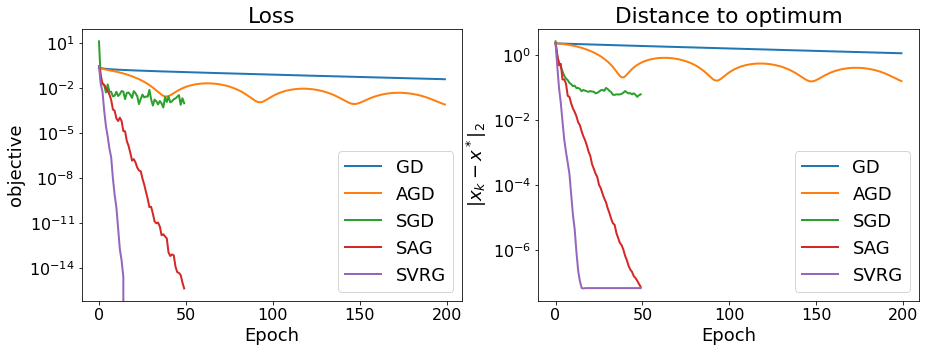

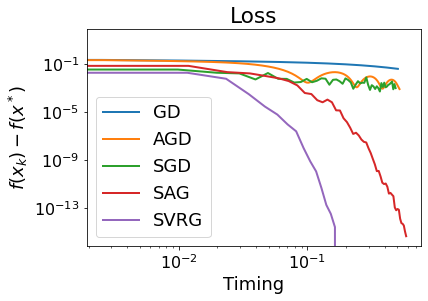

In [ ]:
# Changing regularization parameter
# choosing λ=1/n (corr takes its default value which is 0.9) 
parameters_change(lamb = 1/n)

step = 0.059504916888015735
0.681744492044186
9.541842959162133e-09


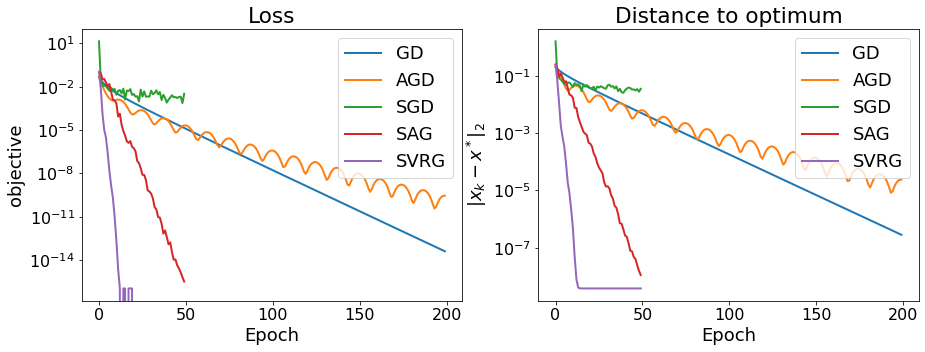

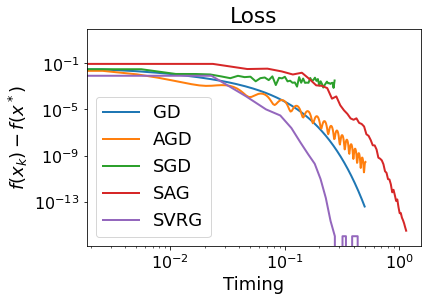

In [ ]:
# choosing λ=1 
parameters_change(lamb = 1)

> **Comments:** <br>
* When fixing the correlation parameter to 0.9 and choosing a high ridge regularization $λ =\frac{1}{n}$, we notice that the AGD has a faster convergence comparing to GD and that the fastest optimization algorithm is SVRG.However, when choosing a low value for λ (λ=1), after a certain number of iterations the GD becomes faster than the AGD and that both converge much more faster than in the case where λ is big. We also notice that for all stochastic methods there is no change when changing the value of λ.

step = 0.7599424161329522
0.5282755339779097
1.090789100509289e-09


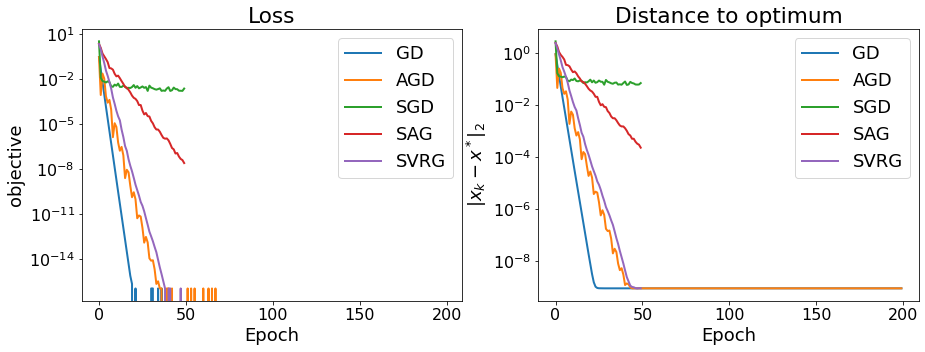

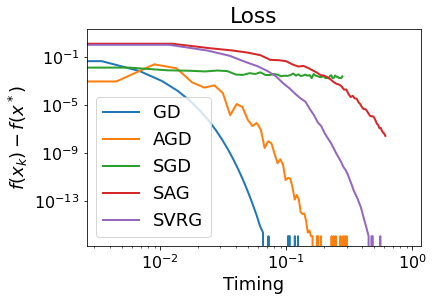

In [ ]:
#3. Playing with corr: 
# changing corr to a small value(lamb takes the default value which is 1/(n**0.5))
parameters_change(corr=0.1)

step = 0.3336418609926209
0.5309496968082437
5.050902142714305e-09


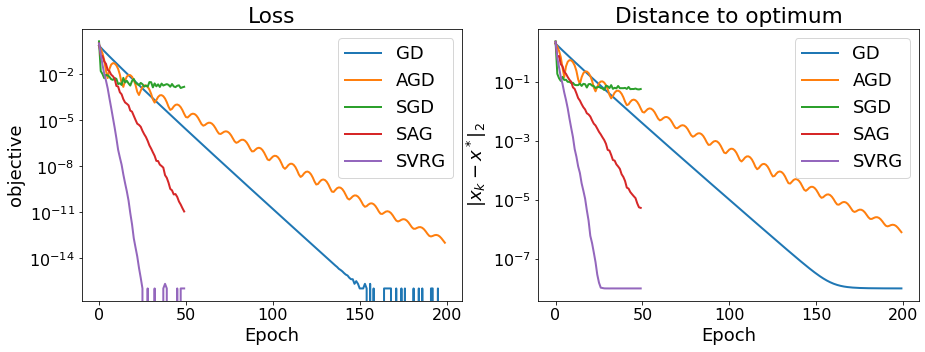

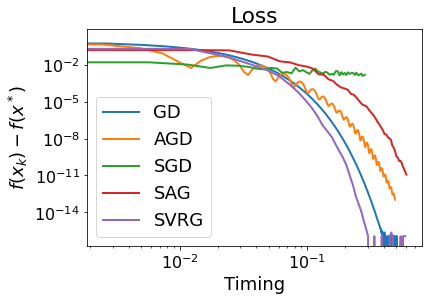

In [ ]:
parameters_change(corr=0.5)

step = 0.11729508233469946
0.5208299120463594
1.4386139885520563e-08


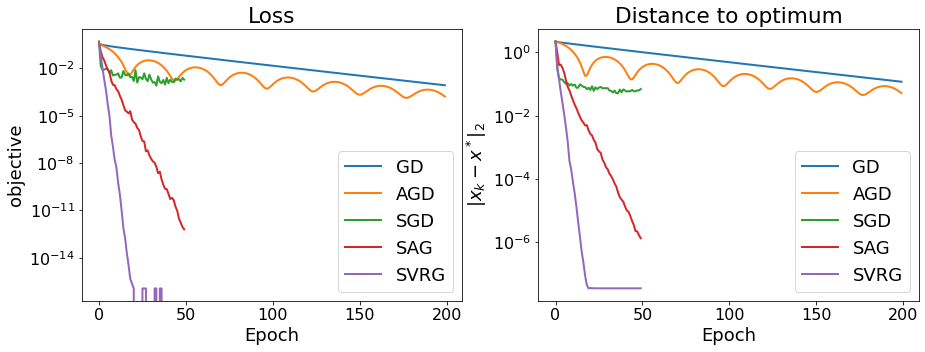

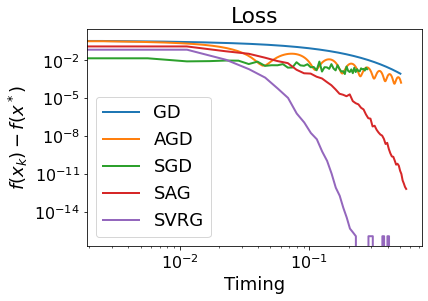

In [ ]:
parameters_change(corr=0.8)

> **Comments:**<br>
- When fixing the ridge regularization parameter to $\frac{1}{\sqrt{n}}$ and choosing a low correlation parameter we notice that GD and SGD converge faster than stochastic methods and that GD have the best convergence performance. The more we increase the value of correlation, the more deterministic methods converge slower and the more stochastic methods become faster.

**4-Conclusion:**<br>
* Only deterministic methods are sensitive to the ridge regularization parameter. Increasing this parameter leads to a better convergence for GD and AGD with GD that has better performances than AGD. However with a high value of λ, stochastic methods remains with best convergence performances comparing to deterministic ones. 
* Both stochastic and deterministic methods are sensitive to the correlation parameter. In fact, when features have a weak correlation deterministic methods converge faster than stochastic methods and have the lowest losses. However, when the features are strongly correlated, stochastic methods outperform GD and SGD.